# kospi200 일별시세 가져오기

#### iframe 페이지 크롤링의 이해
- iframe구조인지 파악(눈치채기) :
    - 페이지가 바뀌는데, url이 안바뀐다.
    - 페이지 구조상 안바뀌는게 맞는 것 같을 때
- html에서 iframe 태그 찾기 -> src 가져오기
- requests.get(iframe_src)

In [ ]:
# 날짜 :    date
# 체결가:  price
# 전일비:  diff
# 등락률:  rate
# 거래량:  volume
# 거래대금:   amount

## 1. 1페이지 날짜, 체결가만 가져와서 출력하기

In [2]:
import requests
from bs4 import BeautifulSoup

In [ ]:
# url = 'https://finance.naver.com/sise/sise_index.naver?code=KPI200'
# resp = requests.get(url)
# resp

# soup = BeautifulSoup(resp.content, 'lxml')
# soup.select('td.date')

[]

In [3]:
url = 'https://finance.naver.com/sise/sise_index_day.naver?code=KPI200'
resp = requests.get(url)
resp

soup = BeautifulSoup(resp.content, 'lxml')
soup.select('td.date')


[<td class="date">2025.05.12</td>,
 <td class="date">2025.05.09</td>,
 <td class="date">2025.05.08</td>,
 <td class="date">2025.05.07</td>,
 <td class="date">2025.05.02</td>,
 <td class="date">2025.04.30</td>]

## 2. 1페이지 전체 데이터 가져와서 아래 각각의 리스트에 저장하기

In [ ]:
dates, diffs, prices, rates, volumns, amounts = [] ,[], [], [], [], []

In [ ]:
url = 'https://finance.naver.com/sise/sise_index_day.naver?code=KPI200'
resp = requests.get(url)
resp

soup = BeautifulSoup(resp.content, 'lxml')

In [4]:
date_tags = soup.select('td.date')
num1_tags = soup.select('td.number_1')
diff_tags = soup.select('td.rate_down')

price_tags = num1_tags[::4]
rate_tags = num1_tags[1::4]
volumn_tags = num1_tags[2::4]
amount_tags = num1_tags[3::4]

len(date_tags), len(diff_tags), len(price_tags), len(rate_tags), len(volumn_tags), len(amount_tags)

(6, 6, 6, 6, 6, 6)

In [ ]:
for i in range(len(date_tags)):
    dates.append(date_tags[i].text)
    diffs.append(float(diff_tags[i].text.strip()))
    prices.append(float(price_tags[i].text.replace(',', '')))
    rates.append(float(rate_tags[i].text.strip().replace('%', '')))
    volumns.append(int(volumn_tags[i].text.replace(',', '')))
    amounts.append(int(amount_tags[i].text.replace(',', '')))

dates, diffs, prices, rates, volumns, amounts

(['2025.01.13',
  '2025.01.10',
  '2025.01.09',
  '2025.01.08',
  '2025.01.07',
  '2025.01.06'],
 [4.2, 0.85, 0.45, 4.06, 0.63, 7.52],
 [330.35, 334.55, 335.4, 334.95, 330.89, 331.52],
 [-1.26, -0.25, 0.13, 1.23, -0.19, 2.32],
 [102361, 139733, 145224, 139753, 133145, 102034],
 [5795513, 8069986, 9806823, 8637880, 7882278, 6779474])

## 3. 전일비는 하락의 경우, 음수로 처리하여 1페이지 전체 정보 데이터프레임으로 저장하기

In [6]:
diffs = []

In [8]:
url = 'https://finance.naver.com/sise/sise_index_day.naver?code=KPI200'
resp = requests.get(url)

soup = BeautifulSoup(resp.content, 'lxml')

diff_tags = soup.select('td.rate_down span')

for diff_tag in diff_tags:

    #print(diff_tag['class']) # list
    diff = float(diff_tag.text.strip())
    if 'nv01' in diff_tag['class']:
        diff = -diff
    diffs.append(diff)
print(diffs)

['tah', 'p11', 'red02']
['tah', 'p11', 'red02']
['tah', 'p11', 'red02']
['tah', 'p11', 'red02']
['tah', 'p11', 'red02']
['tah', 'p11', 'nv01']


## 4. 전체 페이지 전체 데이터 가져와서 csv파일로 저장하기
- 코드 시행 시점 무관하게 맨 끝페이지까지 크롤링하도록 자동화할 것.

In [9]:
url = 'https://finance.naver.com/sise/sise_index_day.naver?code=KOSPI&page=1'
resp = requests.get(url)

soup = BeautifulSoup(resp.content, 'lxml')
lst_tags = soup.select('td.pgRR a')
href = lst_tags[0]['href']
href

'/sise/sise_index_day.naver?code=KOSPI&page=1524'

In [14]:
href.split('page=')[-1]
# href.lstrip('/si_indexday.naver?code=KPI200&page=')
# href.replace('/sise_index_day.naver?code=KPI200&page=', '')

'1524'

In [15]:
lst_pn = int(href.split('page=')[-1])
lst_pn

1524

In [12]:
dates, diffs, prices, rates, volumns, amounts = [] ,[], [], [], [], []

for page in range(1450, lst_pn+1):
    url = f'https://finance.naver.com/sise/sise_index_day.naver?code=KOSPI&page={page}'
    resp = requests.get(url)
    # print(page, resp)
    soup = BeautifulSoup(resp.content, 'lxml')

    dat_tags = soup.select('td.date')
    dif_tags = soup.select('td.rate_down')

    num_tags = soup.select('td.number_1')

    prc_tags = num_tags[::4]
    rat_tags = num_tags[1::4]
    vol_tags = num_tags[2::4]
    amt_tags = num_tags[3::4]

    for i in range(len(dat_tags)):
        if dat_tags[i].text.strip():
            dates.append(dat_tags[i].text)
            diffs.append(dif_tags[i].text.strip())
            prices.append(prc_tags[i].text)
            rates.append(rat_tags[i].text.strip())
            volumns.append(vol_tags[i].text)
            amounts.append(amt_tags[i].text)
        else:
            break


dates, diffs, prices, rates, volumns, amounts

(['1991.07.13',
  '1991.07.12',
  '1991.07.11',
  '1991.07.10',
  '1991.07.09',
  '1991.07.08',
  '1991.07.06',
  '1991.07.05',
  '1991.07.04',
  '1991.07.03',
  '1991.07.02',
  '1991.07.01',
  '1991.06.29',
  '1991.06.28',
  '1991.06.27',
  '1991.06.26',
  '1991.06.25',
  '1991.06.24',
  '1991.06.22',
  '1991.06.21',
  '1991.06.19',
  '1991.06.18',
  '1991.06.17',
  '1991.06.15',
  '1991.06.14',
  '1991.06.13',
  '1991.06.12',
  '1991.06.11',
  '1991.06.10',
  '1991.06.08',
  '1991.06.07',
  '1991.06.05',
  '1991.06.04',
  '1991.06.03',
  '1991.06.01',
  '1991.05.31',
  '1991.05.30',
  '1991.05.29',
  '1991.05.28',
  '1991.05.27',
  '1991.05.25',
  '1991.05.24',
  '1991.05.23',
  '1991.05.22',
  '1991.05.20',
  '1991.05.18',
  '1991.05.17',
  '1991.05.16',
  '1991.05.15',
  '1991.05.14',
  '1991.05.13',
  '1991.05.11',
  '1991.05.10',
  '1991.05.09',
  '1991.05.08',
  '1991.05.07',
  '1991.05.06',
  '1991.05.04',
  '1991.05.03',
  '1991.05.02',
  '1991.05.01',
  '1991.04.30',
  '1991.

In [13]:
import pandas as pd

df_ksp = pd.DataFrame({'날짜' : dates, '체결가' : prices, '전일비' : diffs,
              '등락률' : rates, '거래량' : volumns, '거래대금' : amounts})
df_ksp

,날짜,체결가,전일비,등락률,거래량,거래대금
0,1991.07.13,636.50,4.72,+0.75%,"15,897","247,394"
1,1991.07.12,631.78,10.04,+1.61%,"20,452","313,002"
2,1991.07.11,621.74,7.59,+1.24%,"17,591","270,622"
3,1991.07.10,614.15,0.27,-0.04%,"11,306","164,421"
4,1991.07.09,614.42,2.76,-0.45%,"15,544","230,398"
...,...,...,...,...,...,...
441,1990.01.09,920.21,0.75,+0.08%,"18,646","382,992"
442,1990.01.08,919.46,6.60,+0.72%,"17,577","369,946"
443,1990.01.06,912.86,2.25,-0.25%,"12,519","269,397"
444,1990.01.05,915.11,13.71,-1.48%,"22,179","476,295"


In [ ]:
# (추가 과제) 네이버 금융에서 Kospi 일별시세 정보를 모두 csv로 저장해보세요.
df_ksp.to_csv('코스피_일별시세.csv', encoding='utf-8-sig', index=False)

ksp = pd.read_csv('코스피_일별시세.csv')
ksp

,날짜,체결가,전일비,등락률,거래량,거래대금
0,1991.04.11,641.46,4.29,-0.66%,"5,346","74,981"
1,1991.04.10,645.75,0.29,-0.04%,"8,322","118,050"
2,1991.04.09,646.04,0.42,-0.06%,"5,425","78,025"
3,1991.04.08,646.46,4.54,-0.70%,"5,684","81,658"
4,1991.04.06,651.00,3.14,-0.48%,"5,024","71,000"
...,...,...,...,...,...,...
364,1990.01.09,920.21,0.75,+0.08%,"18,646","382,992"
365,1990.01.08,919.46,6.60,+0.72%,"17,577","369,946"
366,1990.01.06,912.86,2.25,-0.25%,"12,519","269,397"
367,1990.01.05,915.11,13.71,-1.48%,"22,179","476,295"


In [ ]:
ksp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 369 entries, 0 to 368
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   날짜      369 non-null    object 
 1   체결가     369 non-null    float64
 2   전일비     369 non-null    float64
 3   등락률     369 non-null    object 
 4   거래량     369 non-null    object 
 5   거래대금    369 non-null    object 
dtypes: float64(2), object(4)
memory usage: 17.4+ KB


In [ ]:
ksp.head(3) # DataFrame

,날짜,체결가,전일비,등락률,거래량,거래대금
0,1991.04.11,641.46,4.29,-0.66%,"5,346","74,981"
1,1991.04.10,645.75,0.29,-0.04%,"8,322","118,050"
2,1991.04.09,646.04,0.42,-0.06%,"5,425","78,025"


In [ ]:
ksp['등락률'] # Series

,등락률
0,-0.66%
1,-0.04%
2,-0.06%
3,-0.70%
4,-0.48%
...,...
364,+0.08%
365,+0.72%
366,-0.25%
367,-1.48%


In [ ]:
# 날짜정보는 datetime으로, 나머지는 numeric으로 변경 후, 통계치 및 시각화를 수행해보세요.
ksp['등락률'] = ksp['등락률'].str.replace('%', '')
ksp['거래량'] = ksp['거래량'].str.replace(',', '')
ksp['거래대금'] = ksp['거래대금'].str.replace(',', '')

# # ksp['등락률'].replace('%', '')  vs  ksp['등락률'].str.replace('%', '')
# ksp['등락률'].replace('%', '') # value 중에 % 인 value를 ''로 변경
# ksp['등락률'].str.replace('%', '') # value에 %가 포함되어있는 value에 %를 ''로 변경
ksp['날짜'] = pd.to_datetime(ksp['날짜'])
ksp['등락률'] = pd.to_numeric(ksp['등락률'])
ksp['거래량'] = pd.to_numeric(ksp['거래량'])
ksp['거래대금'] = pd.to_numeric(ksp['거래대금'])
ksp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 369 entries, 0 to 368
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   날짜      369 non-null    datetime64[ns]
 1   체결가     369 non-null    float64       
 2   전일비     369 non-null    float64       
 3   등락률     369 non-null    float64       
 4   거래량     369 non-null    int64         
 5   거래대금    369 non-null    int64         
dtypes: datetime64[ns](1), float64(3), int64(2)
memory usage: 17.4 KB


In [ ]:
a = [1, 3, 2]
sorted(a), a

([1, 2, 3], [1, 3, 2])

In [ ]:
a.sort()
a

[1, 2, 3]

In [ ]:
ksp.sort_values('날짜', ascending=True, ignore_index=True, inplace=True)
ksp

,날짜,체결가,전일비,등락률,거래량,거래대금
0,1990-01-04,928.82,20.23,2.23,18094,405061
1,1990-01-05,915.11,13.71,-1.48,22179,476295
2,1990-01-06,912.86,2.25,-0.25,12519,269397
3,1990-01-08,919.46,6.60,0.72,17577,369946
4,1990-01-09,920.21,0.75,0.08,18646,382992
...,...,...,...,...,...,...
364,1991-04-06,651.00,3.14,-0.48,5024,71000
365,1991-04-08,646.46,4.54,-0.70,5684,81658
366,1991-04-09,646.04,0.42,-0.06,5425,78025
367,1991-04-10,645.75,0.29,-0.04,8322,118050


In [ ]:
ksp.describe() # 기초 통계치 계산

,체결가,전일비,등락률,거래량,거래대금
count,4214.000000,4214.000000,4214.000000,4214.000000,4.214000e+03
mean,261.789696,0.031440,0.021512,111786.773849,4.705644e+06
std,59.783468,3.105404,1.284720,57742.902151,2.577656e+06
min,123.270000,-16.650000,-10.330000,36693.000000,1.383859e+06
25%,230.385000,-1.490000,-0.580000,73153.500000,3.086526e+06
50%,256.205000,0.150000,0.060000,94626.000000,3.967430e+06
75%,286.582500,1.680000,0.677500,131035.250000,5.480928e+06
max,440.400000,19.410000,12.230000,622950.000000,3.737996e+07


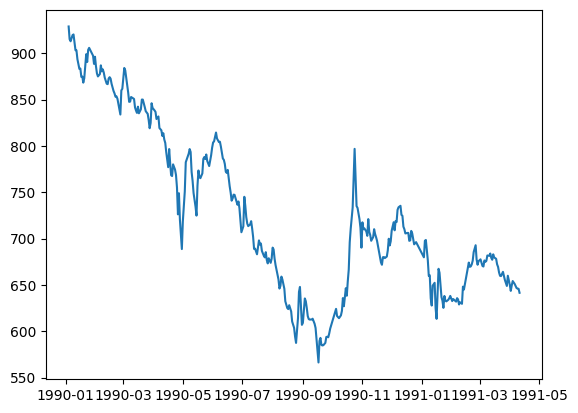

In [ ]:
from matplotlib import pyplot as plt

plt.plot(ksp['날짜'], ksp['체결가'])

<BarContainer object of 369 artists>

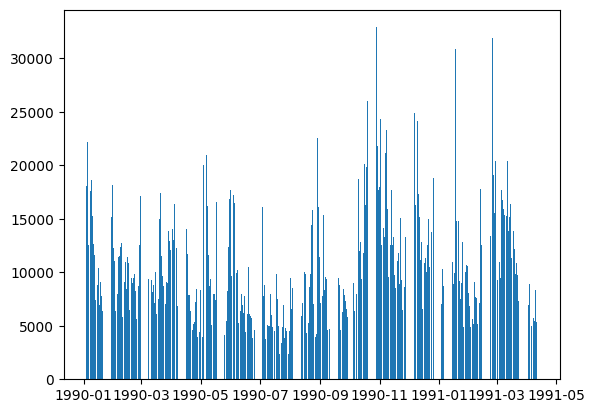

In [ ]:
plt.bar(ksp['날짜'], ksp['거래량'])